In [109]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import csv
import json
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time as time

In [110]:
with open('./train.txt') as train_speed_file:
    speed_ground=train_speed_file.readlines()
print (len(speed_ground))

20400


In [112]:
def brightness_augmentation(img,brightness_factor):
    hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     print hsv_image.shape
    hsv_image[:,:,2] = hsv_image[:,:,2]*brightness_factor
    img = np.array(hsv_image, dtype = np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

In [113]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

def batch_shuffle(dframe):
    dframe_for_split=dframe[:-1]
    
    kfold = KFold(len(dframe_for_split), 4, True)
    
    trainS=[]
    validationS=[]
        
    for train, validation in kfold:
    
        train_data = []
        validation_data = []

        train_set=set()

        for i in train:
            row=dframe.iloc[[i]]
            idx1=int(row['frame'])
            idx2=idx1+1
            train_data.append((idx1,idx2))

            train_set.add(idx1)
            train_set.add(idx2)

        for i in validation:
            row=dframe.iloc[[i]]
            idx1=int(row['frame'])
            idx2=idx1+1
            if idx1 not in train_set and idx2 not in train_set:
                validation_data.append((idx1,idx2))

#         print "train",train_data
        trainS.append(train_data)
        validationS.append(validation_data)
#         print "validation",validation_data
    
    return zip(trainS,validationS)

In [114]:
def preprocessing(image_path, brightness_factor=None):
    img=cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if brightness_factor:
        img = brightness_augmentation(img, brightness_factor)
    img = cv2.resize(img[100:440, :-90], (220, 66), interpolation = cv2.INTER_AREA)
    return img

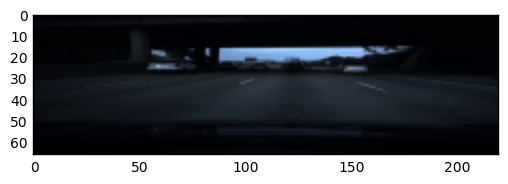

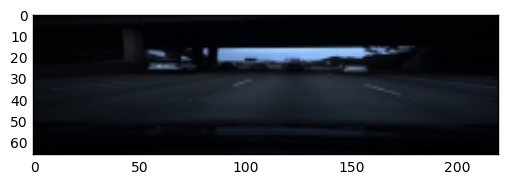

In [115]:
def computeOpticalFlow(img1,img2):  #Dense Optical Flow
    
    gray1=cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
    gray2=cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros_like(img1)
    hsv[...,1] = 255
    
    # 2-channel array with optical flow vectors
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, flow=None, pyr_scale=0.5, 
                                        levels=3, winsize=15, iterations=3, 
                                        poly_n=5, poly_sigma=1.2, flags=0)
    
    # find their magnitude and direction
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
#     print (mag)
#     for i in mag:
#         print (i,len(i))
#         print ()
    
    # color code the result for better visualization. 
    
    # Direction corresponds to Hue value of the image.
    hsv[...,0] = ang*180/np.pi/2
    
    # Magnitude corresponds to Value plane. 
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
#     print (cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX))
    
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    return rgb

# img1=preprocessing('./IMG/10.jpg')
# img2=preprocessing('./IMG/11.jpg')
# plt.imshow(img1)
# plt.show()
# plt.imshow(img2)
# plt.show()
# x=computeOpticalFlow(img1,img2)

In [116]:
import copy
def generate_training_data(tuples, data, batch_size=32):
    channels=3
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    batch_data = []
    batch_labels = []
    
    for j in range(len(tuples) * 2 //batch_size): #*2
        for i in range(0,batch_size,2): #,2
            idx = np.random.randint(1, len(tuples) - 1)

            brightness_factor=0.2 + np.random.uniform()

            row1=data.iloc[[tuples[idx][0]]] #idx
            row2=data.iloc[[tuples[idx][1]]] #idx
            
            #print(row1['image_path'])
            img1 = preprocessing(row1['image_path'].values[0],brightness_factor)
            img2 = preprocessing(row2['image_path'].values[0],brightness_factor)
            #print row1['image_path']
            #print row2['image_path']
            
            speed1 = row1['speed'].values[0]
            speed2 = row2['speed'].values[0]

            resimg = computeOpticalFlow(img1,img2)
            speed = np.mean([speed1, speed2])
            
            image_batch[i] = resimg
            label_batch[i] = speed
            
            # flip the same image and save with same label
            
            ## flipping the image pair
            aug_img1 = np.flip(img1, 1)
            aug_img2 = np.flip(img2, 1)
            aug_resimg = computeOpticalFlow(aug_img1,aug_img2)

            image_batch[i+1] = aug_resimg
            label_batch[i+1] = speed # speed remains the same
            
        img_batch=image_batch
        img_batch = np.reshape(img_batch, (batch_size, channels, 66, 220))
        
        batch_data.append(copy.deepcopy(torch.from_numpy(img_batch)))
        batch_labels.append(copy.deepcopy(torch.DoubleTensor(label_batch)))
    
    return zip(batch_data, batch_labels)

In [117]:
def generate_validation_data(tuples,data,batch_size=32):
    channels=3
    val_image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    val_label_batch = np.zeros((batch_size))
    batch_data_val = []
    batch_labels_val = []
    output = []
    
    for j in range(len(tuples)//batch_size):
        for i in range(0,batch_size):
            idx = np.random.randint(1, len(tuples) - 1)
            
            row1=data.iloc[[tuples[idx][0]]] #idx
            row2=data.iloc[[tuples[idx][1]]] #idx

            img1 = preprocessing(row1['image_path'].values[0])
            img2 = preprocessing(row2['image_path'].values[0])
            
            speed1 = row1['speed'].values[0]
            speed2 = row2['speed'].values[0]
            
            resimg = computeOpticalFlow(img1,img2)
            
            speed = np.mean([speed1, speed2])
            
            val_image_batch[i] = resimg
            val_label_batch[i] = speed
        
        val_img_batch=val_image_batch
        val_img_batch = np.reshape(val_img_batch, (batch_size, channels, 66, 220))
        
        batch_data_val.append(copy.deepcopy(torch.from_numpy(val_img_batch)))
        batch_labels_val.append(copy.deepcopy(torch.DoubleTensor(val_label_batch)))
        
    return zip(batch_data_val, batch_labels_val)

In [118]:
import torch.optim as optim

img_size=(66,220,3)

class NvidiaNet(nn.Module):
    def __init__(self):
        super(NvidiaNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5,stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5,stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5,stride=2)
        self.conv3_drop = nn.Dropout2d()
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3,stride=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3,stride=1)
        self.fc1 = nn.Linear(1280, 1164)
        self.fc2 = nn.Linear(1164, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        self.fc5 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = self.conv3_drop(F.elu(self.conv3(x)))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        x = x.view(-1, 1280)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = self.fc5(x)
        return x

In [119]:
# net = torch.load('./dense_optical_flow_simple.pkl')

In [166]:
def trainNvidiaNet(train_df, net, criterion, optimizer, train_loss_k_folds, val_loss_k_folds):
    xyS = batch_shuffle(train_df)

    for j, (x,y) in enumerate(xyS):    
        batch_size=32

        train_loss = []
        val_losses = []

        trainloader=list(generate_training_data(x,train_df,batch_size))
        train_num = len(trainloader)
        print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_size))

        validationloader=list(generate_validation_data(y,train_df,batch_size))
        validation_num = len(validationloader)
        print("Finish loading %d minibatches(=%d) of validation samples." % (validation_num, batch_size))
        print 

        for epoch in range(10):  # loop over the dataset multiple times        
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = net(inputs.cuda())

                labels=labels.view(-1,1)
                loss = criterion(outputs, labels.cuda())
                loss.backward()
                optimizer.step()

                train_loss.append(loss.item())

        for i, dataval in enumerate(validationloader, 0):
            inputs, labels = dataval

            outputs = net(inputs.cuda())
            labels=labels.view(-1,1)

            val_loss = criterion(outputs, labels.cuda())

            val_losses.append(val_loss.item())

        train_loss_k_folds.append(copy.deepcopy(train_loss))
        val_loss_k_folds.append(copy.deepcopy(val_losses))
    return net


In [167]:
train_start_time = time.time()

model_save_path="./"

net = NvidiaNet().cuda()
net = net.double()

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

train_loss_k_folds = []
val_loss_k_folds = []

train_df = pd.read_csv('./trainSemseg.csv')
net = trainNvidiaNet(train_df, net, criterion, optimizer, train_loss_k_folds, val_loss_k_folds)

print("1 done")

train_df = pd.read_csv('./train.csv')
net = trainNvidiaNet(train_df, net, criterion, optimizer, train_loss_k_folds, val_loss_k_folds)

torch.save(net, model_save_path+"dense_optical_flow_both.pkl")
print('Finished Training .. saved model ')

train_end_time = time.time() - train_start_time
print('------------------------------------------------------------')
print("time taken to TRAIN for DenseOpticalFlow  in seconds {:.3f}".format(train_end_time))

Finish loading 956 minibatches(=32) of training samples.
Finish loading 10 minibatches(=32) of validation samples.
Finish loading 956 minibatches(=32) of training samples.
Finish loading 9 minibatches(=32) of validation samples.
Finish loading 956 minibatches(=32) of training samples.
Finish loading 9 minibatches(=32) of validation samples.
Finish loading 956 minibatches(=32) of training samples.
Finish loading 10 minibatches(=32) of validation samples.
1 done
Finish loading 956 minibatches(=32) of training samples.
Finish loading 10 minibatches(=32) of validation samples.
Finish loading 956 minibatches(=32) of training samples.
Finish loading 10 minibatches(=32) of validation samples.
Finish loading 956 minibatches(=32) of training samples.
Finish loading 8 minibatches(=32) of validation samples.
Finish loading 956 minibatches(=32) of training samples.
Finish loading 8 minibatches(=32) of validation samples.
Finished Training .. saved model 
-------------------------------------------

/home/shrinand_thakkar/anaconda3/lib/python3.5/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type NvidiaNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [168]:
avg_k_train_loss=0.0
avg_k_val_loss=0.0
for i in range(4):
    avg_k_train_loss+=np.mean(train_loss_k_folds[i])
    avg_k_val_loss+=np.mean(val_loss_k_folds[i])
#     print ("train_loss ", i, " ", np.mean(train_loss_k_folds[i]))
#     print ("val_loss ", i, " ", np.mean(val_loss_k_folds[i]))
print ("avg_k_train_loss ",avg_k_train_loss/4.)
print ("avg_k_val_loss ",avg_k_val_loss/4.)

avg_k_train_loss  8.152381380683535
avg_k_val_loss  7.023207750500324


In [169]:
###########################
# TESTING
###########################

In [175]:
# test_df = pd.read_csv('./testSemseg_new.csv')
test_df = pd.read_csv('./test.csv')
len(test_df)

8616

In [176]:
def generate_test_data(data,batch_size):
    channels=3
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    batch_data = []
    batch_labels = []

    for j in range(len(data)//batch_size):
        for i in range(batch_size):
            if (i+j*batch_size)+1 == len(data):
                break
            row1=data.iloc[[i+j*batch_size]]
            row2=data.iloc[[(i+j*batch_size)+1]]
            
            img1 = preprocessing(row1['image_path'].values[0])
            img2 = preprocessing(row2['image_path'].values[0])

            speed1 = row1['speed'].values[0]
            speed2 = row2['speed'].values[0]

            resimg = computeOpticalFlow(img1,img2)
            resimg = resimg.reshape(1, resimg.shape[0], resimg.shape[1], resimg.shape[2])
            
            speed = np.mean([speed1, speed2])
            speed = np.array([[speed]])
            
            image_batch[i] = resimg
            label_batch[i] = speed
        
        img_batch=image_batch
        img_batch = np.reshape(img_batch, (batch_size, channels, 66, 220))
        
        batch_data.append(torch.from_numpy(img_batch))
        batch_labels.append(torch.DoubleTensor(label_batch))
        
    return zip(batch_data, batch_labels)

batch_size=32

testloader=list(generate_test_data(test_df,batch_size))
test_num = len(testloader)
print("Finish loading %d minibatches(=%d) of validation samples." % (test_num, batch_size))

Finish loading 269 minibatches(=32) of validation samples.


In [178]:
test_start_time = time.time()
test_losses = []
criterion = nn.MSELoss().cuda()

for i, datatest in enumerate(testloader, 0):
    inputs, labels = datatest
    
    outputs = net(inputs.cuda())
    labels=labels.view(-1,1)
    
    test_loss = criterion(outputs, labels.cuda())

    test_losses.append(test_loss.item())
          
print('Testing done')
test_end_time = time.time() - test_start_time
print('------------------------------------------------------------')
print("time taken to TEST for DenseOpticalFlow  in seconds {:.3f}".format(test_end_time))

Testing done
------------------------------------------------------------
time taken to TEST for DenseOpticalFlow  in seconds 0.998


In [179]:
print (np.mean(test_losses))

24.29630063113779


In [180]:
print (min(test_losses))

7.395641024371403


In [177]:
test_seg_results =  test_losses

In [181]:
test_results = test_losses

In [182]:
improvements=[]
calc=[]
for i in range(269):
    if test_seg_results[i]<test_results[i]:
        improvements.append(i)
        calc.append(test_seg_results[i])
    else:
        calc.append(test_results[i])


In [183]:
print (improvements)

[0, 2, 5, 9, 14, 18, 21, 22, 23, 25, 28, 34, 37, 39, 40, 43, 46, 47, 48, 49, 61, 66, 75, 77, 81, 82, 85, 86, 87, 90, 94, 95, 96, 97, 103, 104, 106, 109, 111, 113, 114, 116, 121, 125, 126, 128, 130, 134, 138, 140, 145, 146, 147, 150, 151, 154, 159, 169, 170, 171, 173, 174, 176, 178, 183, 184, 185, 186, 190, 193, 194, 195, 199, 200, 202, 204, 207, 209, 213, 214, 215, 219, 222, 224, 229, 232, 236, 244, 245, 248, 249, 250, 251, 252, 256, 258, 259, 260, 262, 267]


In [184]:
print (np.mean(calc))

21.611105618469516
